In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
# Read the full earthquake catalog
df = pd.read_csv("./clean_quakes.csv")

In [ ]:
# Oops, the latitude and longitude are swapped, need to fix the column headers to match data.

df.rename(columns={'lat': 'newlong', \
                        'long': 'newlat'}, inplace=True)

In [ ]:
df.rename(columns={'newlong': 'long', \
                        'newlat': 'lat'}, inplace=True)

In [ ]:
# Define function to filter on the Oklahoma quakes

# Determine latitude/longitude box
#  Latitude  34  -  37
#  Longitude -94.5  -  -100

def OK_quake(df, id):
    is_OK_quake = False
    qlat, qlong = df[df['id'] == id]['lat'].item(), df[df['id'] == id]['long'].item()
    if (qlat >= 34) and (qlat <= 37):
        if (qlong >= -100) and (qlong <= -94.5):
            is_OK_quake = True
    return is_OK_quake    
    
      
print OK_quake(df, 'usp0007upe')   # test of one known to be in Oklahoma
 


In [ ]:
df.head()

In [ ]:
# Read the detailed earthquake dyfi information file
df_dyfi = pd.read_csv("./dyfi_mmi.csv")


In [ ]:

def ok_q(qid):
    is_OK_quake = 0
    qlat, qlong = df[df['id'] == qid]['lat'].item(), df[df['id'] == qid]['long'].item()
    if (qlat >= 34) and (qlat <= 37):
        if (qlong >= -100) and (qlong <= -94.5):
            is_OK_quake = 1
    return is_OK_quake    


# ok_q('usp00009ad')

OK_mask = list(df_dyfi.loc[0:200]['id'].map(lambda x: ok_q(x)))

In [ ]:
current_quake_id = 'start'
next_quake_id = df_dyfi.iloc[0]['id']
idx = 0
length = len(df_dyfi)
while idx < length:
    
    if idx % 1000 == 0:
        print "Processing records", idx, " to", idx+1000, ".  Current quake id is", current_quake_id
    
    # Get quake id for next set of dyfi records
    if next_quake_id != current_quake_id:
        current_quake_id = next_quake_id
    
        # Check if is an Oklahoma quake
        current_quake_OK_flag = ok_q(current_quake_id) 
    
    
    # Update each dyfi record sharing same quake id with the quake magnitude, depth, lat, long and time
    df_dyfi.loc[idx, 'is_OK'] = current_quake_OK_flag
    
        
    # Step through all dyfi records with same quake id
    idx += 1
    if idx < length:
        next_quake_id = df_dyfi.iloc[idx]['id']

print "Finished updating Oklahoma flag"     

In [ ]:
# df_dyfi.to_csv("./dyfi_OK.csv", index=False) 

## Load Oklahoma quakes

In [62]:
df_dyfi = pd.read_csv("./dyfi_OK.csv")

In [99]:
i = 3045
c = df_dyfi.loc[i,'distance']
b = df_dyfi.loc[i,'depth']
print c, b, c**2, b**2, c**2+b**2

5.0 7.0 25.0 49.0 74.0


In [104]:
# Correct epicentral distance to hypocentral distance

# The hypocenter of an earthquake is the location beneath the earth’s surface where the 
# rupture of the fault begins. The epicenter of an earthquake is the location directly
# above the hypocenter on the surface of the earth.

# ISSUE:  Some distances are less than depth,  an impossibility if the distance is truly hypocentral
# Perhaps the hypocentral vs epicentral distance reports are ambiguous ?

corr_dist = []
for i in range(len(df_dyfi)):
#     if i % 1000 == 0:
#         print "Processing records", i, " to", i+1000

    if not df_dyfi.loc[i, 'is_epi_dist']:  # Leave hypocentral distances unchanged
        corr_dist.append(df_dyfi.loc[i,'distance'])
    else:                           # convert epicentral distance to hypocentral distance
        corrected_distance = np.sqrt((df_dyfi.loc[i,'distance']**2 + df_dyfi.loc[i,'depth']**2))
        corr_dist.append(corrected_distance)
#         print i, (df_dyfi.loc[i,'depth'], df_dyfi.loc[i,'distance'], corrected_distance)

df_dyfi['hypocentral_distance'] = corr_dist

In [120]:
df_dyfi[df_dyfi['hypocentral_distance'] > df_dyfi['distance']+30].shape

(34, 20)

In [121]:
ok_dyfi = df_dyfi[df_dyfi['is_OK']==1]

In [122]:
print len(ok_dyfi)
print len(ok_dyfi[ok_dyfi['mmi'].notnull()])

39937
27507


In [ ]:
# # Removing distances more than 4 standard deviations from mean
# dist_std = ok_dyfi['distance'].std()
# dist_mean = ok_dyfi['distance'].mean()

# ok_dyfi['dist_std_dev'] = ok_dyfi['distance'].map(lambda x: (x-dist_mean)/dist_std )


In [123]:
ok_dyfi.describe()

,cdi_Latitude,cdi_Longitude,is_suspect,responses,is_epi_dist,distance,cdi,mmi,mag,depth,q_lat,q_long,is_OK,hypocentral_distance
count,39937.000000,39937.000000,39937.0,39937.000000,39937.000000,39937.000000,39937.000000,27507.000000,39937.000000,39937.000000,39937.000000,39937.000000,39937.0,39937.000000
mean,36.431779,-96.370051,0.0,6.898315,0.087112,211.158149,2.675419,5.221508,4.143819,5.398599,35.985073,-97.281349,1.0,211.203629
std,1.945146,2.256614,0.0,23.852668,0.282003,214.097819,0.805613,1.180371,0.950150,1.722149,0.493651,0.582596,0.0,214.058717
min,26.257100,-115.261600,0.0,1.000000,0.000000,1.000000,1.000000,2.650000,2.500000,0.000000,34.069000,-99.632300,1.0,1.000000
25%,35.489500,-97.494200,0.0,1.000000,0.000000,57.000000,2.000000,4.210000,3.400000,4.875000,35.534000,-97.553500,1.0,57.000000
50%,36.053400,-97.092700,0.0,1.000000,0.000000,148.000000,2.600000,5.050000,4.000000,5.200000,35.919800,-97.174100,1.0,148.000000
75%,37.576700,-95.815100,0.0,4.000000,0.000000,291.000000,3.200000,6.740000,4.800000,5.825000,36.425100,-96.799700,1.0,291.000000
max,48.855800,-72.702200,0.0,734.000000,1.000000,2257.000000,7.200000,6.800000,5.800000,16.500000,36.996300,-94.962200,1.0,2257.000000


In [66]:
# ok_dyfi = ok_dyfi[(ok_dyfi['dist_std_dev'] <= 4) & (ok_dyfi['dist_std_dev'] >= -4)]

In [124]:
ok_dyfi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39937 entries, 3044 to 272938
Data columns (total 20 columns):
id                      39937 non-null object
cdi_Latitude            39937 non-null float64
cdi_Longitude           39937 non-null float64
city                    39937 non-null object
state                   39937 non-null object
zip_code                39937 non-null object
is_suspect              39937 non-null int64
responses               39937 non-null int64
is_epi_dist             39937 non-null int64
distance                39937 non-null float64
cdi                     39937 non-null float64
mmi                     27507 non-null float64
mag                     39937 non-null float64
mag_type                39937 non-null object
depth                   39937 non-null float64
q_lat                   39937 non-null float64
q_long                  39937 non-null float64
q_time                  39937 non-null object
is_OK                   39937 non-null float64
hypoce

In [125]:
factors = [ x for x in ok_dyfi.columns if x not in ['cdi_Latitude', 'cdi_Longitude', 'q_lat', 'q_long', \
                                              'city', 'state', 'is_suspect', 'id', 'q_time', 'q_hour',  \
                                               'zip_code',  'mag_type', 'depth', 'is_OK', 'is_epi_dist', \
                                               'cdi', 'mmi', 'distance', 'dist_std_dev']]
print factors
X = ok_dyfi[(ok_dyfi['responses'] >=5) ][factors]
y = ok_dyfi[(ok_dyfi['responses'] >=5) ]['cdi'].values
X = X.drop(['responses'], 1)
factors = [ x for x in ok_dyfi.columns if x not in ['cdi_Latitude', 'cdi_Longitude', 'q_lat', 'q_long', \
                                              'city', 'state', 'is_suspect', 'id', 'q_time', 'q_hour',  \
                                               'zip_code', 'mag_type', 'depth', 'is_OK', 'responses', 'is_epi_dist', \
                                               'cdi', 'distance', 'dist_std_dev']]

print y[0:5]
print len(X)
X.head()

['responses', 'mag', 'hypocentral_distance']
[ 3.2  3.9  3.5  3.9  3.7]
8527


,mag,hypocentral_distance
3044,2.9,9.0
3047,2.9,4.0
3048,2.9,12.0
3049,2.9,9.0
3050,2.9,9.0


(array([    4.,   709.,  2023.,  2964.,  1718.,   842.,   217.,    36.,
            9.,     5.]),
 array([ 1.  ,  1.61,  2.22,  2.83,  3.44,  4.05,  4.66,  5.27,  5.88,
         6.49,  7.1 ]),
 <a list of 10 Patch objects>)

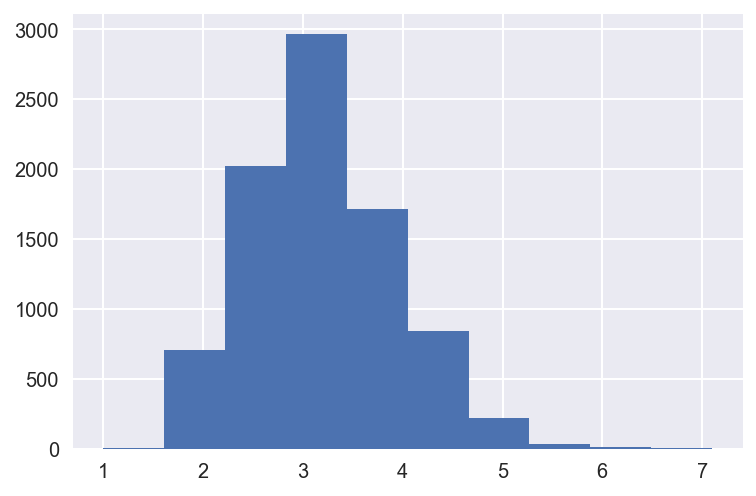

In [126]:
plt.hist(y)

(array([  4.48700000e+03,   2.25500000e+03,   1.13900000e+03,
          3.31000000e+02,   2.69000000e+02,   2.20000000e+01,
          2.30000000e+01,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([    2. ,   155.1,   308.2,   461.3,   614.4,   767.5,   920.6,
         1073.7,  1226.8,  1379.9,  1533. ]),
 <a list of 10 Patch objects>)

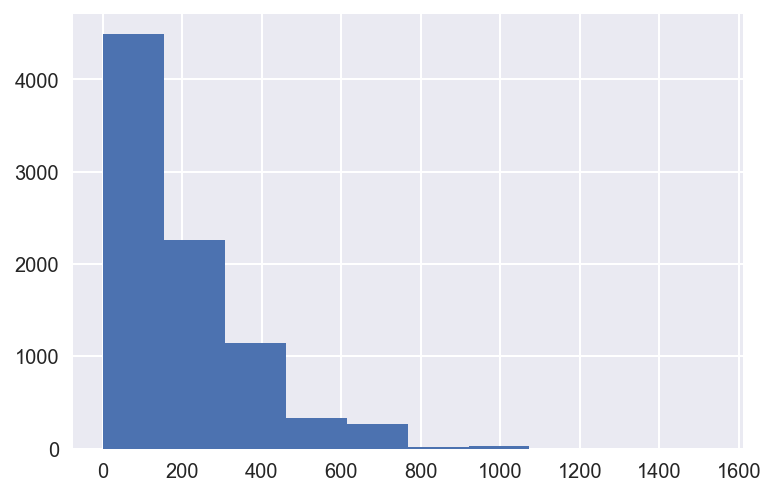

In [127]:
plt.hist(X['hypocentral_distance'])

(array([  206.,   248.,   484.,   658.,   504.,  1442.,  1503.,   413.,
            0.,  3069.]),
 array([ 2.5 ,  2.83,  3.16,  3.49,  3.82,  4.15,  4.48,  4.81,  5.14,
         5.47,  5.8 ]),
 <a list of 10 Patch objects>)

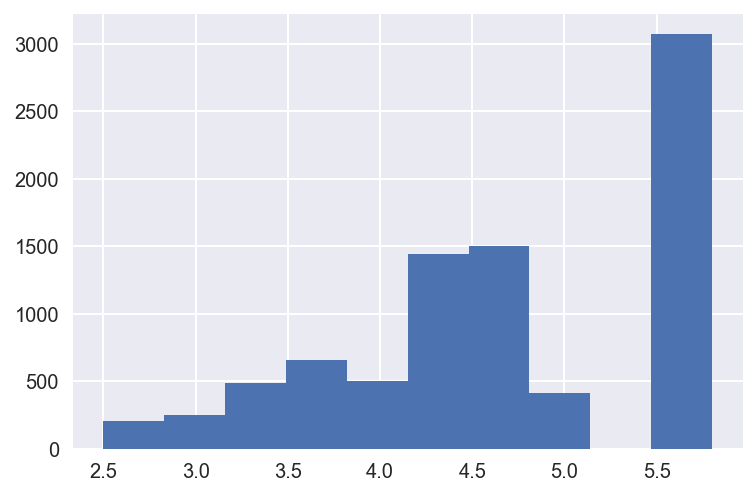

In [128]:
plt.hist(X['mag'])

In [73]:
# plt.hist(X['depth'])

### Begin a Linear Regression model

In [129]:
# import scipy.stats as stats
from sklearn import linear_model, metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, cross_val_predict

from sklearn.preprocessing import StandardScaler

In [131]:
# Feature engineer a log distance column
def log_scale(n):
    if n == 0:
        n = 0.01
    return np.log10(n) 

X['log_dist'] = X['hypocentral_distance'].map(lambda x: log_scale(x))
# X['log_depth'] = X['depth'].map(lambda x: log_scale(x))
X.head()

,mag,hypocentral_distance,log_dist
3044,2.9,9.0,0.954243
3047,2.9,4.0,0.602060
3048,2.9,12.0,1.079181
3049,2.9,9.0,0.954243
3050,2.9,9.0,0.954243


In [132]:
X.describe()

,mag,hypocentral_distance,log_dist
count,8527.000000,8527.000000,8527.000000
mean,4.734889,187.223074,2.011885
std,0.917201,173.876625,0.560199
min,2.500000,2.000000,0.301030
25%,4.200000,43.000000,1.633468
50%,4.700000,146.000000,2.164353
75%,5.700000,272.000000,2.434569
max,5.800000,1533.000000,3.185542


In [133]:
factors = [ x for x in X.columns]
factors

['mag', 'hypocentral_distance', 'log_dist']

In [134]:
# Test train split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [45]:
# Standardize - almost always a good idea, and for many models a necessary practice.  
# Nothing in this dataset has characteristics that would preclude standardization

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

# Fit and transform the data for training set using standard scaler.
# Only Transform the test set.

Xstd_train = ss.fit_transform(X_train[factors])
Xstd_test = ss.transform(X_test[factors])

# Check reasonablness of result
print Xstd_train.mean(), Xstd_train.std()
print Xstd_train.shape
print
print Xstd_test.mean(), Xstd_test.std()
print Xstd_test.shape


8.83317396293e-17 1.0
(6395, 3)

0.00666748424715 1.01047929332
(2132, 3)


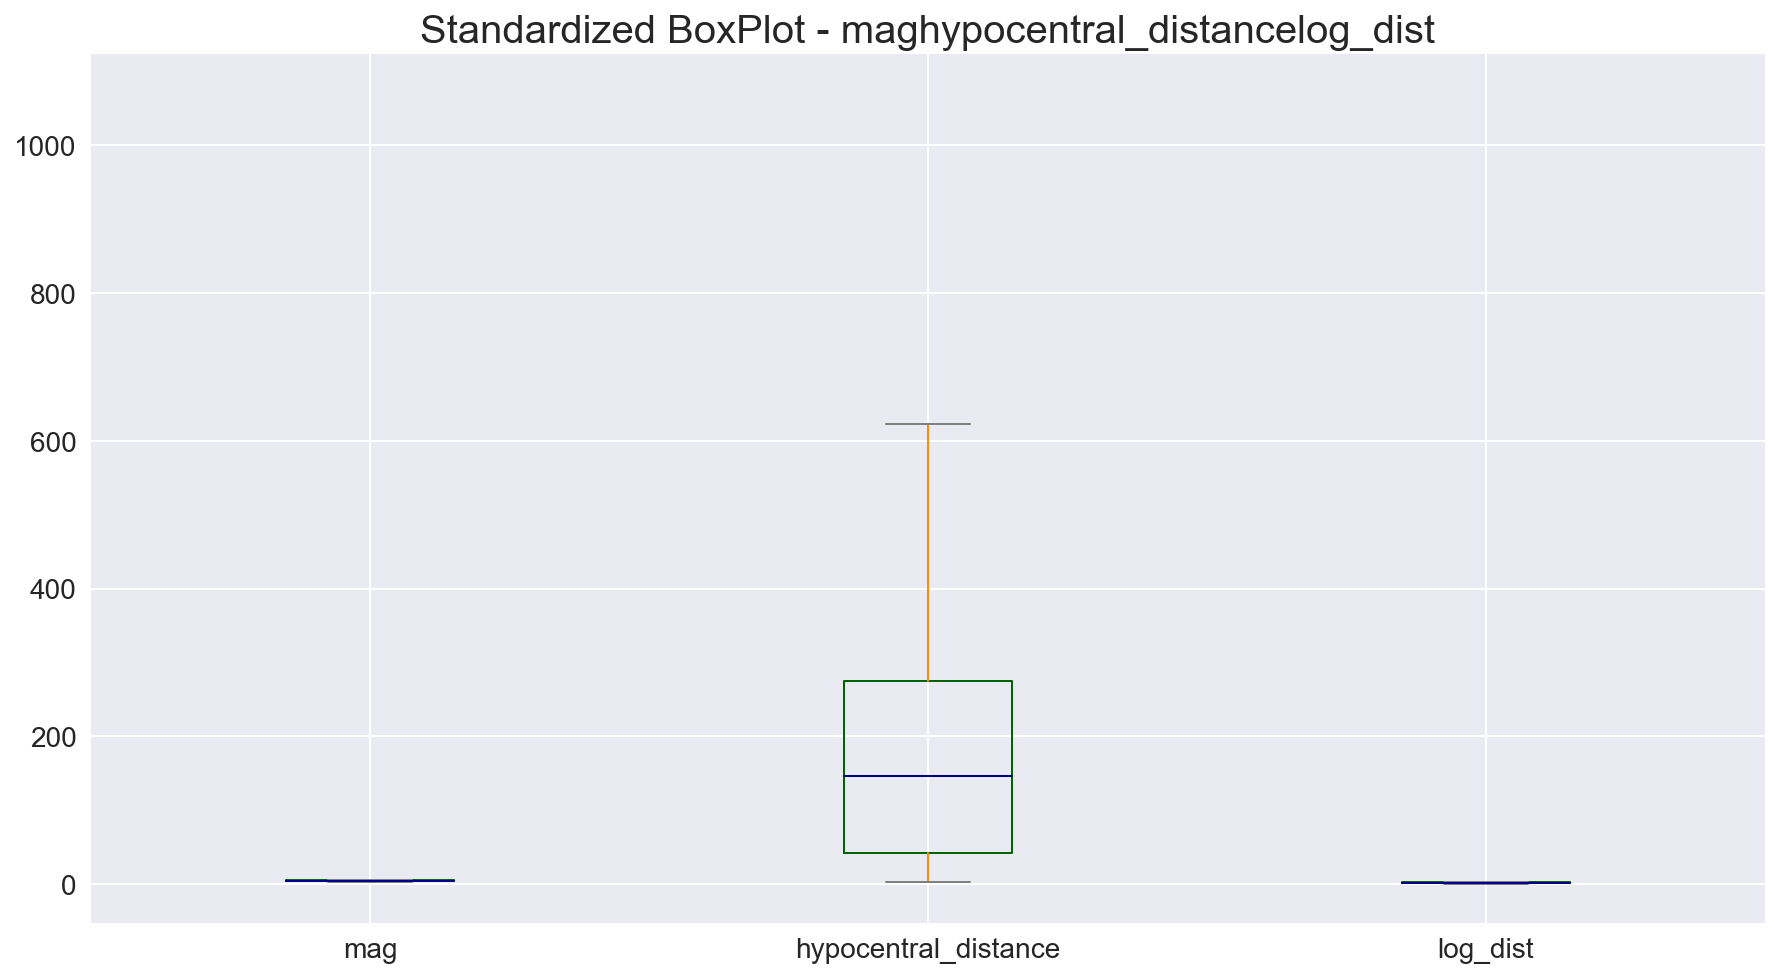

In [135]:
# Box plot vs. Scatter plot vs. Histogram.  While all of these give you a view of the spread of your data, the
#   - Box plot best at showing outliers if there are any
#   - Histogram gives the easiest and most intuitive look at the distribution
#   - Scatter plot is best at showing the correlation between two variables, and the "tightness" of that correlation

# The Rate should not be plotted on same box plot as the Math and Verbal because the scale, and also range, 
# are not the same, or even similar.

# Set colors, as this shows up better on the grey back ground
color = dict(boxes='DarkGreen', whiskers='DarkOrange', \
                medians='DarkBlue', caps='Gray')

# ax = X.loc[:, ['distance', 'mag', 'depth']].plot.box(color=color, figsize=(15,8), fontsize=14, \
#                                        title="BoxPlot - Distance, Magnitude, Depth")

ax = pd.DataFrame(X_train, columns=factors)[factors].plot.box(color=color,\
                         figsize=(15,8), fontsize=14, \
                         title="Standardized BoxPlot - " + ''.join([str(x) for x in factors]))
ax.title.set_size(20)


In [136]:
print len(Xstd_train), len(Xstd_test)

6395 2132


In [137]:
# Compute baseline

baseline = np.mean(y)
print baseline

3.21005042805


score: 0.471754972434
[ 0.81784065 -0.0017311  -0.88008035]
1.43407313681
MSE:  0.270648540263
RMSE:  0.520238926132
Baseline: 3.21005042805
Baseline - MSE: 2.93940188779


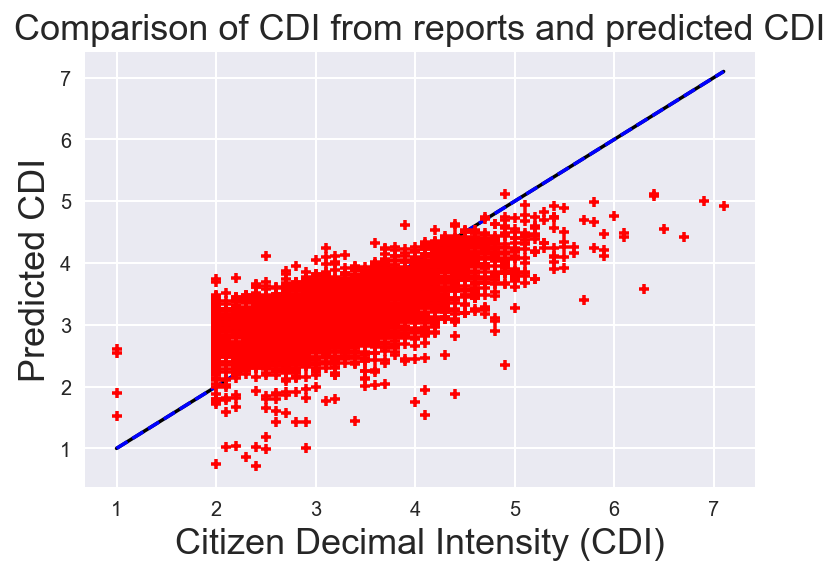

In [138]:
# Linear Regression Model

lm = linear_model.LinearRegression()

model = lm.fit(X_train, y_train)

# Linear Regression with plot of predicted vs. actual y
predictions = model.predict(X_train)
score = model.score(X_train, y_train)
print "score:", score
print model.coef_
print model.intercept_

# Calculate the RMSE of model using sklearn.metrics.mean_squared_error.
mse = mean_squared_error(y_train, predictions)
rmse = np.sqrt(mse)

print "MSE: ", mse
print "RMSE: ", rmse
print "Baseline:", baseline
print "Baseline - MSE:", baseline - mse

plt.scatter(y_train, predictions, s=30, c='r', marker='+', zorder=10)
plt.plot([min(y_train),max(y_train)],[min(y_train),max(y_train)],c='k')
plt.plot([min(y_train),max(y_train)],[min(y_train),max(y_train)],c='k', linestyle='dashed', color="b")
plt.xlabel('Citizen Decimal Intensity (CDI)', fontsize=18)
plt.ylabel('Predicted CDI', fontsize=18)
plt.title('Comparison of CDI from reports and predicted CDI', fontsize=18)

# I did this just to see how closely the training data was fit to itself.  When compared to the 
# predictions for test data, it will give a good indication if this model over fits

Score: 0.467580191943
MSE:  0.259814344124
RMSE:  0.509719868285
Baseline: 3.21005042805
Baseline - MSE: 2.95023608393


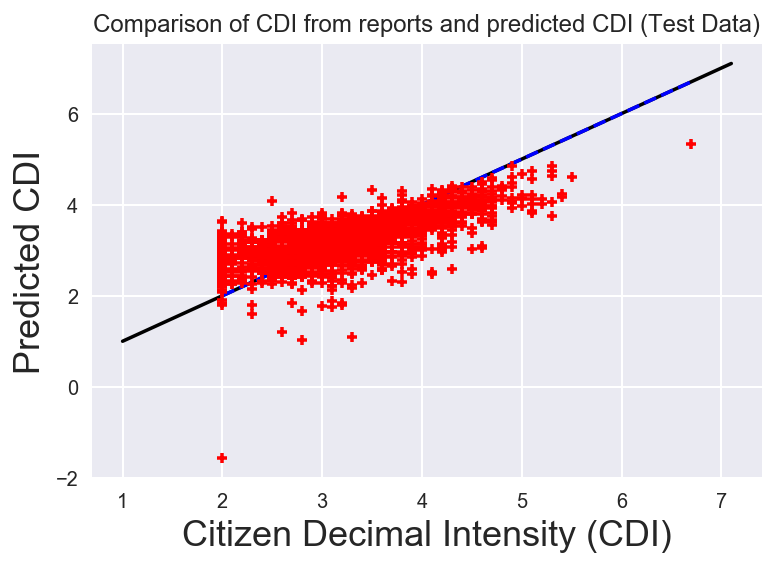

In [139]:
# Using the model above, now fit and plot against the test data
# Linear Regression with plot of predicted vs. actual y

predictions = model.predict(X_test)
score = model.score(X_test, y_test)
print "Score:", score

# Calculate the RMSE of model using sklearn.metrics.mean_squared_error.
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print "MSE: ", mse
print "RMSE: ", rmse
print "Baseline:", baseline
print "Baseline - MSE:", baseline - mse

# pd.DataFrame(zip(all_sig_factors, model.coef_), columns=['factors', 'coefficients'])
# df_model_summary = pd.DataFrame([['LM', 'All Factors', len(factors), score, mse, rmse, baseline]], \
#                                 columns=['Model', 'Factors', '# Factors','Score', 'MSE', 'RMSE', 'Baseline'])

plt.scatter(y_test, predictions, s=30, c='r', marker='+', zorder=10)
plt.plot([min(y_train),max(y_train)],[min(y_train),max(y_train)],c='k')
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)],c='k', linestyle='dashed', color="b")
plt.xlabel('Citizen Decimal Intensity (CDI)', fontsize=18)
plt.ylabel('Predicted CDI', fontsize=18)
plt.title('Comparison of CDI from reports and predicted CDI (Test Data)')

# T

In [6]:
def USGS_West(mag, dist):
    return 1.01 * mag - 0.00054 * dist - 1.72 * np.log10(dist) + 1.15

def USGS_East(mag, dist):
    return 1.29 * mag - 0.00051 * dist - 2.16 * np.log10(dist) + 1.60

def Schroyer_OK(mag, dist):
    return 0.93 * mag - 1.15 * np.log10(dist) + 1.14

def USGS_West_CDI(mag, dist):
    c1 = 12.27
    c2 = 2.770
    c3 = 0.1304
    c4 = -1.30
    c5 = -0.0007070
    c6 = 1.95
    c7 = -0.577
    h = 14.0
    Rt = 30.0
    if dist <= Rt:
        B = 0
    else:
        B = np.log10(dist/Rt)
    return c1 + c2*(mag-6) -c3*(mag-6)**2 + c4*np.log10(dist) + c5*dist + c6*B + c7*mag*np.log10(dist)

def USGS_East_CDI(mag, dist):
    c1 = 11.72
    c2 = 2.36
    c3 = 0.1155
    c4 = -0.44
    c5 = -0.002044
    c6 = 2.31
    c7 = -0.479
    h = 17.0
    Rt = 80.0
    if dist <= Rt:
        B = 0
    else:
        B = np.log10(dist/Rt)
    return c1 + c2*(mag-6) -c3*(mag-6)**2 + c4*np.log10(dist) + c5*dist + c6*B + c7*mag*np.log10(dist)


def This_model(mag, dist):
    return  0.82 * mag \
            - 0.0017 * dist \
            - 0.88 * np.log10(dist) \
            + 1.43

# distance      mag        log_dist
# [-0.00173382  0.81103743 -0.85743055]
# 1.4182915241

#   mag   hypocentral distance log_dist
# [ 0.81784065 -0.0017311  -0.88008035]
# 1.43407313681

In [141]:
print This_model(2,1)

3.0683


In [97]:
USGS_East(2.6, 20/1.61)

2.5841836978678878

In [61]:
ss.inverse_transform()

{'copy': True, 'with_mean': True, 'with_std': True}

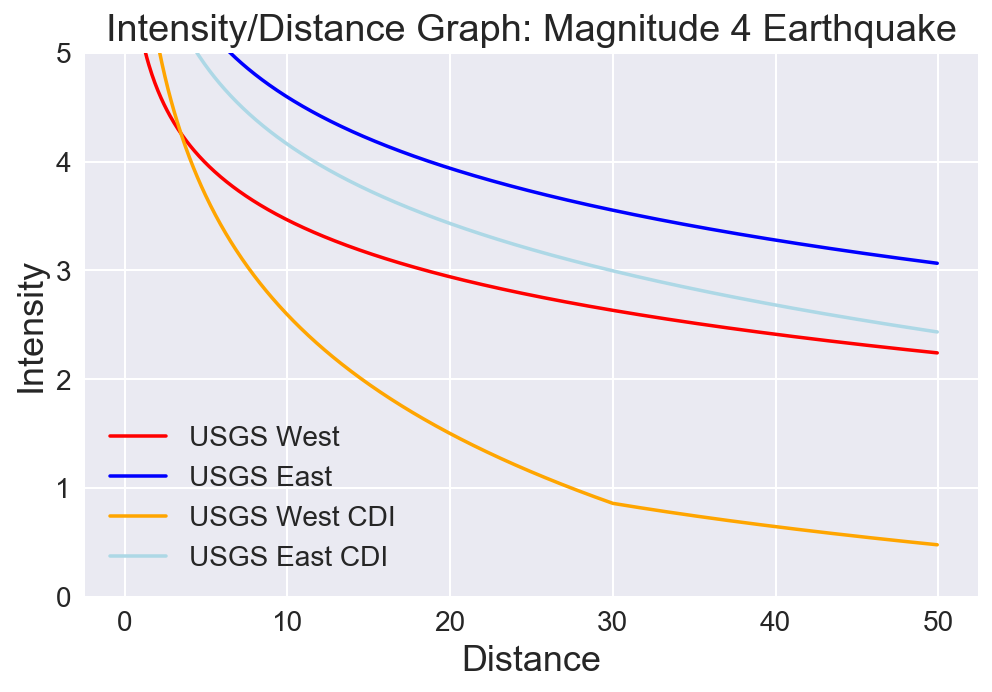

In [9]:
# Generate Distance values
dist = np.arange(0.1, 50*1.61, 0.1)
mag = 4

WI = []
WCDI = []
EI = []
ECDI = []
OI = []
EH = []
for i in range(len(dist)):
    WI.append(USGS_West(mag, dist[i]/1.61))
    EI.append(USGS_East(mag, dist[i]/1.61))
    OI.append(Schroyer_OK(mag, dist[i]/1.61))
    WCDI.append(USGS_West_CDI(mag, dist[i]/1.61))
    ECDI.append(USGS_East_CDI(mag, dist[i]/1.61))
    EH.append(This_model(mag, dist[i]/1.61))
    
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(dist/1.61, WI, label='USGS West', color='r') 
ax.plot(dist/1.61, EI, label='USGS East', color='b')
# ax.plot(dist/1.61, OI, label='Schroyer OK', color='grey')
ax.plot(dist/1.61, WCDI, label='USGS West CDI', color='orange')
ax.plot(dist/1.61, ECDI, label='USGS East CDI', color='lightblue')

# ax.plot(dist/1.61, EH, label='My model using Oklahoma data', color='green')

x1,x2,y1,y2  = ax.axis()
ax.axis((x1,x2,0,5))
plt.xlabel('Distance', fontsize=18)
plt.ylabel('Intensity', fontsize=18)
plt.tick_params(labelsize=14)
title_string = 'Intensity/Distance Graph: Magnitude ' + str(mag) + ' Earthquake'
plt.title(title_string, fontsize=19)
ax.legend(fontsize=14)

plt.show()